In [6]:
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda

from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [0]:
X = np.load('X.npy')
y = np.load('y.npy')

In [8]:
print(X.shape, y.shape)

(7227, 60, 80, 3) (7227,)


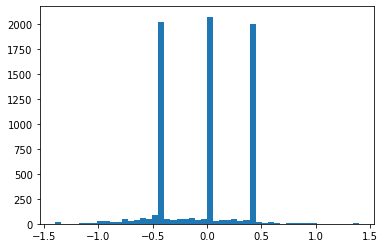

In [9]:
plt.hist(y, 50);

0.0


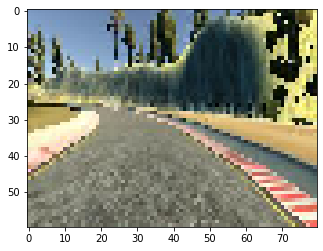

-0.42500000000000004


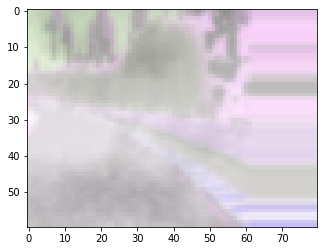

In [10]:
#  A function that modifies the image given on the input
def augment(img, steering_angle):
  #  Flip
  if random.random() > 0.5:   #  Generating numbers between 0 and 1
    img = img[:, ::-1, :]     #  Mirror image
    steering_angle = -steering_angle  #  Changing the angle to negative when the image is inverted
  #  Blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 1.0))
  img = blurer.augment_image(img)
  #  Shuffle - Random color change between RGB channels
  sh = iaa.ChannelShuffle(p=0.5)   #  50% random probability
  img = sh.augment_image(img)
  #  Fog - weather conditions
  fog = iaa.Fog()
  img = fog.augment_image(img)
  #  Translate
  tx = random.randint(-20,20)
  translater = iaa.Affine(translate_px={"x":tx}, mode='edge')
  img = translater.augment_image(img)
  steering_angle += tx*0.025  #  image shift 
  return img, steering_angle

plt.imshow(X[0])  #  First image from the collection
print(y[0])
plt.show();

#  First image and first angle
img, angle = augment(X[0], y[0])
plt.imshow(img)
print(angle)
plt.show();

In [0]:
#  Division of the data set into training and validation 80:20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2020)

In [12]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(5781, 60, 80, 3) (5781,)
(1446, 60, 80, 3) (1446,)


In [13]:
#  Generate examples of images to train
Xgen=[]
ygen=[]

for i in range(X_train.shape[0]):
  img, angle = augment(X[i], y[i])
  #  Adding data to tables
  Xgen.append(img)
  ygen.append(angle)

#  Converting data to matrix
Xgen = np.array(Xgen)
ygen = np.array(ygen)

print(Xgen.shape, ygen.shape)

(5781, 60, 80, 3) (5781,)


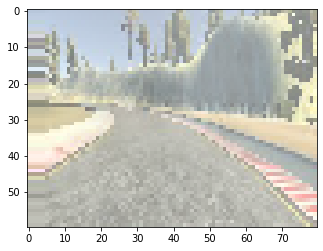

In [14]:
plt.imshow(Xgen[0]);

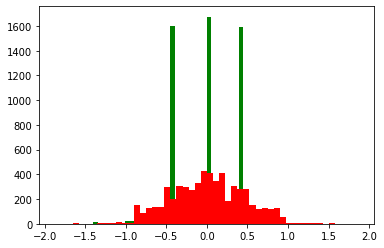

In [15]:
plt.hist(y_train, 50, facecolor='green');
plt.hist(ygen, 50, facecolor='red');

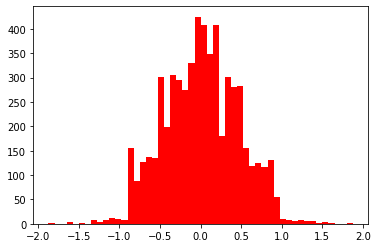

In [16]:
plt.hist(ygen, 50, facecolor='red');

In [17]:
def myModel(input_shape):
  model = Sequential([
      #  Shift images from 0 to 255 to -0.5 to 0.5
      Lambda(lambda x: (x-128.0)/255.0, input_shape=input_shape, name='normalize'),
      Conv2D(64,(3,3), activation='relu'),  
      Conv2D(32,(3,3), activation='relu'),  
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(16,(3,3), activation='relu'),  
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(8,(3,3), activation='relu'),  
      MaxPooling2D(pool_size=(2,2)),
      Dropout(rate=0.5),
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(16, activation='relu'),
      Dense(1), 
  ])
  return model
model = myModel(X[0].shape)
model.summary()
model.compile('adam', 'mse')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 18, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 16, 8)        

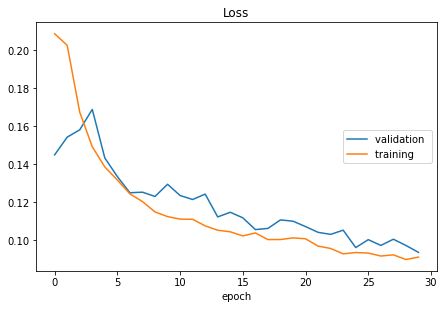

Loss
	validation       	 (min:    0.093, max:    0.169, cur:    0.093)
	training         	 (min:    0.090, max:    0.209, cur:    0.091)


In [18]:
batch_size = 512   #  The number of photos that goes into training at once
epochs = 30

#  Network training
model.fit(Xgen, ygen,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val),
          callbacks=[PlotLossesKeras()])

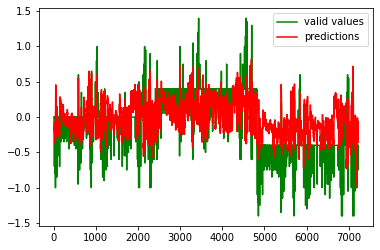

In [19]:
#  Network prediction for the entire set
ypred = model.predict(X)
plt.plot(y, 'g', ypred, 'r')
plt.legend(('valid values', 'predictions'))
plt.show();

In [0]:
model.save('my_model.h5')